**Objective** Study why our customers churn, can we predict customer behavior, and how can we improve customer retention?

Initial hypothesis from stakeholders

- Could the sign-up month (e.g. specific promo lead to sign-up cohort) relate to customer churn? 


- Is there a cohort or cohorts who have a higher rate of churn than other cohorts? 
  (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers))


- Are there features that indicate a higher propensity to churn? 
> internet service 
>
> type of phone service
>
> type of online security and backup
>
> senior citizens
>
> paying more than x% of customers with the same services


- Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?


- If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [1]:
import pandas as pd
import numpy as np
import env
import acquire
import prep

import warnings
warnings.filterwarnings("ignore")

# Data Acquisition & Cleaning

In [2]:
df = acquire.get_data_from_mysql()
df.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,DSL,Month-to-month,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,DSL,Month-to-month,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,DSL,Month-to-month,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,DSL,Month-to-month,Bank transfer (automatic)


In [3]:
df = prep.basic_clean(df)

In [5]:
# tenure & monthly_charges might need to be scaled

# Baseline modles prepared with baseline preparation

- Split train 80%/ test 20%

- Encode target variable "churn"

- Perform first iteration of model construction with only numeric features 

- Use decision tree algorithm with hyper-parameter setting as: criterion = 'gini', max_depth = 5, random_state = 123

- 2nd model: with decision tree, using statistically significantly relevant features (numerical & categorical)

- 3rd model: with logistic regression, using statistically significantly relevant features (numerical & categorical)

In [4]:
train, test = prep.split_my_data(df)

In [5]:
# if monthly, 0, not monthly, 1
train["Monthly_or_not"] = np.where(train["contract_type"] == 'Month-to-month', "Monthly", "Contract")

In [11]:
test["Monthly_or_not"] = np.where(test["contract_type"] == 'Month-to-month', "Monthly", "Contract")

In [6]:
train, test = prep.encode(train, test, "churn")

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [12]:
X_train = train.drop(columns = train.select_dtypes(object).columns)
X_train = X_train.drop(columns = "churn")
y_train = train.churn
X_test = test.drop(columns = train.select_dtypes(object).columns)
X_test = X_test.drop(columns = "churn")
y_test = test.churn

In [13]:
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 5, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [10]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [14]:
y_pred = clf.predict(X_train)
label = sorted(y_train.unique())

In [15]:
y_pred_proba = clf.predict_proba(X_train)

In [16]:
output = pd.DataFrame(data=y_pred_proba, index=list(X_train.index), columns= ["STAY %","CHURN %"]) 

In [17]:
output["Prediction"] = np.where(output["STAY %"] > output["CHURN %"], 'Stay', 'Churn')

In [23]:
output["Actual"] = train.churn

In [24]:
output.to_csv(r'pred_decision_tree_all_num.csv')

In [13]:
pd.DataFrame(confusion_matrix(y_train, y_pred), index=label, columns=label)

,0,1
0,3856,294
1,837,638


In [14]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      4150
           1       0.68      0.43      0.53      1475

    accuracy                           0.80      5625
   macro avg       0.75      0.68      0.70      5625
weighted avg       0.79      0.80      0.78      5625



In [134]:
import graphviz
from graphviz import Graph
from sklearn import tree
import pydotplus
import sklearn.tree as tree

In [135]:
# Export resulting tree to DOT source code string
dot_data = export_graphviz(clf,
                           feature_names=X_train.columns,
                           out_file=None,
                           filled=True,
                           rounded=True)

#Export to pdf
pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_pdf('telco_base_tree.pdf')

True

In [26]:
feature = ['senior_citizen', 'online_security', 'online_backup', 'partner', 'dependents', 'multiple_lines',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'paperless_billing', 'internet_service_type', 'contract_type',
       'payment_type']

In [27]:
for col in feature:
    train_2, test_2 = prep.encode(train, test, col)

In [28]:
re_X_train = train_2[['monthly_charges', 'senior_citizen', 'online_security', 'online_backup', 'partner', 'dependents', 'multiple_lines', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'internet_service_type', 'contract_type', 'payment_type']]
re_y_train = train_2.churn

re_X_test = test_2[['monthly_charges', 'senior_citizen', 'online_security', 'online_backup', 'partner', 'dependents', 'multiple_lines', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'paperless_billing', 'internet_service_type', 'contract_type', 'payment_type']]
re_y_test = test_2.churn

In [27]:
clf2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state=123)
clf2.fit(re_X_train, re_y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [28]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'.format(clf2.score(re_X_train, re_y_train)))

Accuracy of Decision Tree classifier on training set: 0.78


In [29]:
y_pred2 = clf2.predict(re_X_train)
label2 = sorted(re_y_train.unique())

In [30]:
print(classification_report(re_y_train, y_pred2))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      4150
           1       0.62      0.44      0.52      1475

    accuracy                           0.78      5625
   macro avg       0.72      0.67      0.69      5625
weighted avg       0.77      0.78      0.77      5625



In [35]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(C=1, class_weight={1:2}, random_state = 123, solver='saga')

In [54]:
logit.fit(re_X_train, re_y_train)

LogisticRegression(C=1, class_weight={1: 2}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred3 = logit.predict(re_X_train)

In [56]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(re_X_train, re_y_train)))

Accuracy of Logistic Regression classifier on training set: 0.75


In [39]:
print(classification_report(re_y_train, y_pred3))

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      4150
           1       0.52      0.75      0.61      1475

    accuracy                           0.75      5625
   macro avg       0.71      0.75      0.72      5625
weighted avg       0.80      0.75      0.77      5625



In [57]:
y_pred_proba3 = logit.predict_proba(re_X_train)

In [45]:
logit_out = pd.DataFrame(data=y_pred_proba3, index=list(re_X_train.index), columns= ["STAY %","CHURN %"]) 

In [58]:
logit_out["Prediction"] = np.where(logit_out["STAY %"] > logit_out["CHURN %"], 'Stay', 'Churn')
logit_out["Actual"] = train.churn
logit_out.to_csv(r'pred_logit_selected_features.csv')

In [51]:
y_pred4 = logit.predict(re_X_test)
y_pred_proba4 = logit.predict_proba(re_X_test)

In [52]:
logit_out2 = pd.DataFrame(data=y_pred_proba4, index=list(re_X_test.index), columns= ["STAY %","CHURN %"]) 

In [53]:
logit_out2["Prediction"] = np.where(logit_out2["STAY %"] > logit_out2["CHURN %"], 'Stay', 'Churn')
logit_out2["Actual"] = test.churn
logit_out2.to_csv(r'pred_logit_validate_test_selected_features.csv')

**Takeaway from the baseline model** 
- With only numeric features and the decision tree algorithm, the in-sample accuracy of decision tree is 80%.
- Adding in categorical features did not improve model performance.
- Use of logistic regression brought down the precision of predicting customers who churn.

- **Overall, logistic regression model performs better.**

Text(0.5, 1.0, 'Churn Rate For Each Tenure Period')

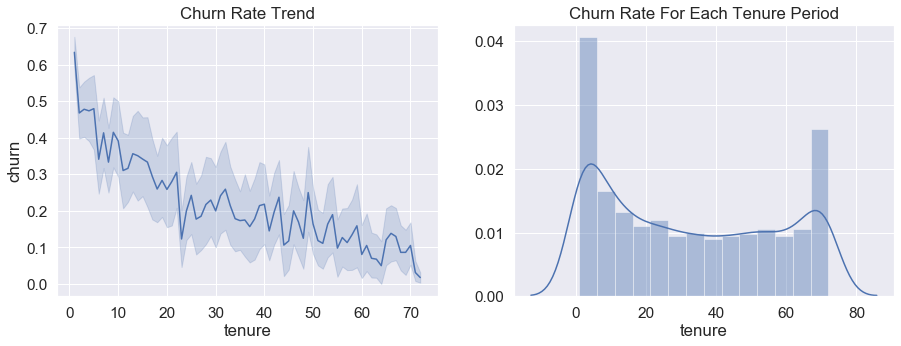

In [20]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

sns.lineplot(x="tenure", y="churn", data=train, ax = ax1).set_title("Churn Rate Trend")
sns.distplot(train[["tenure","churn"]].tenure, ax = ax2).set_title("Churn Rate For Each Tenure Period")

In [147]:
# Ratio of people who churned only after 5 months
print("Ratio of customers who churned {:.3f}".format\
(len(train[(train.churn == 1)]) / len(train.churn)))

Ratio of customers who churned 0.262


In [204]:
# Ratio of people who churned only after 5 months
print("Ratio of customers churned within 5 months {:.3f}".format(train[train.tenure <= 5].churn.mean()))

Ratio of customers churned within 5 months 0.548


In [206]:
# Ratio of people who churned between 5 months & 2 years
print("Ratio of customers churned between 6 months to 2 years {:.3f}".format(train[(train.tenure > 5) & (train.tenure < 24)].churn.mean()))

Ratio of customers churned between 6 months to 2 years 0.325


In [205]:
# Ratio of people who churned after 2 yaers
print("Ratio of customers churned after 2 years {:.3f}".format(train[train.tenure >24].churn.mean()))

Ratio of customers churned after 2 years 0.137


**Takeaway** The overall trend indicates the most customer churn appear in the first 5 months.

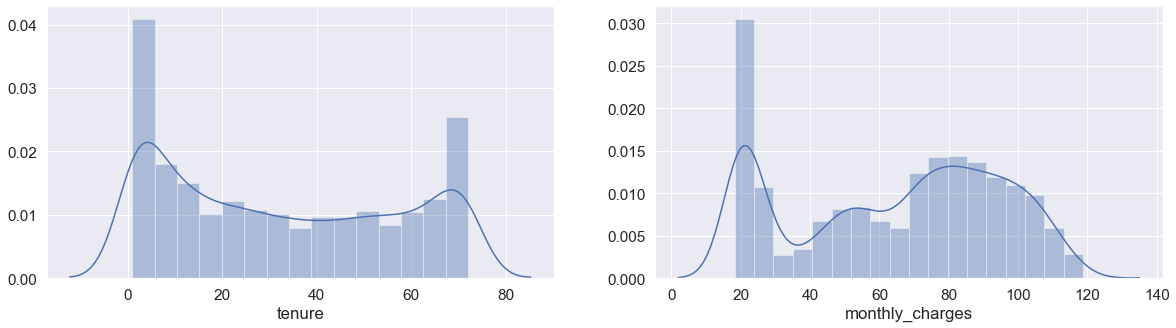

In [32]:
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

sns.distplot(df.tenure, ax = ax1)
sns.distplot(df.monthly_charges, ax = ax2)

In [12]:
print("Proportion of customer without contract:")
print("{:.2f}".format((train["Monthly_or_not"] == "Monthly").mean()))

Proportion of customer without contract:
0.55


In [120]:
train.Monthly_or_not.value_counts()

Monthly     3084
Contract    2541
Name: Monthly_or_not, dtype: int64

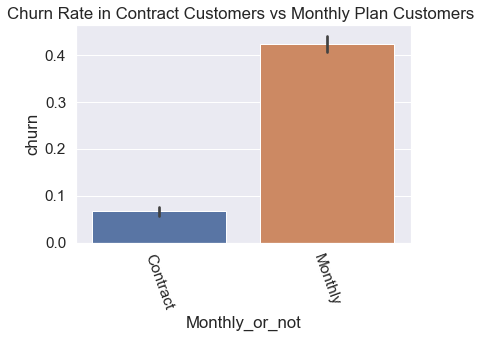

In [129]:
fig = sns.barplot(x="Monthly_or_not", y="churn", data=train)
plt.title('Churn Rate in Contract Customers vs Monthly Plan Customers ')
plt.xticks(rotation=-70)
plt.show()

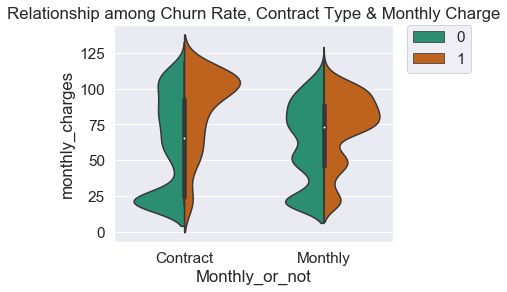

In [50]:
fig = plt.figure(figsize=(5,4))
gs = gridspec.GridSpec(1, 1)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot('Monthly_or_not', 'monthly_charges', hue='churn', data=train, split=True, palette="Dark2", ax = ax1)
plt.title('Relationship among Churn Rate, Contract Type & Monthly Charge')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# name_of_plot.fig.savefig(figure_output_path)  

In [209]:
print('The churn rate after 12 months for a month-to-month contract:')
print("{:.3f}".format(train [(train.tenure > 12) & (train.contract_type == "Month-to-month")].churn.mean()))
print('The churn rate after 12 months for a one-year contract:')
print("{:.3f}".format(train [(train.tenure > 12) & (train.contract_type == "One year")].churn.mean()))

The churn rate after 12 months for a month-to-month contract:
0.328
The churn rate after 12 months for a one-year contract:
0.108


**Takeaway:** 
- Increase of monthly charge leading to higher churn rate is more prominant in contract customers.  
- Although higher proportion of non-contract customers who churned is also shown above, but definitely not as significant.
- Price range of approximately 20.00 - 60.00 in non-contract customers reflected slightly higher customer retention, which will be further studied.

In [81]:
keep_mo = train[(train["Monthly_or_not"] == "Monthly") & (train["monthly_charges"] < 60)]

In [101]:
left = train[(train["Monthly_or_not"] == "Monthly") & (train["monthly_charges"] > 60)]

In [33]:
study_mo = train[(train["Monthly_or_not"] == "Monthly")]

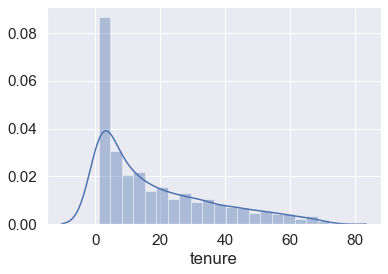

In [128]:
sns.distplot(study_mo.tenure)

In [62]:
import scipy as sp

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

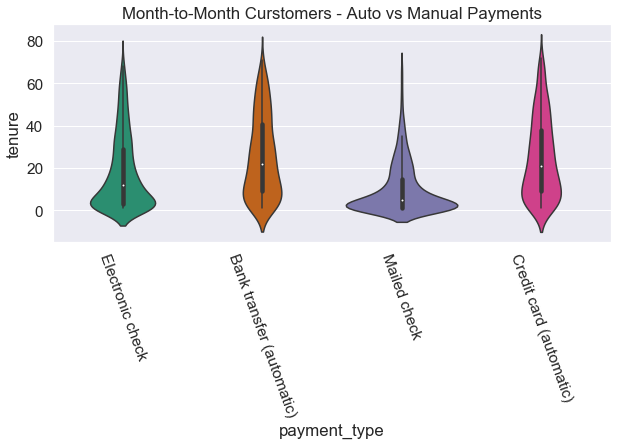

In [40]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 1)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot('payment_type', 'tenure', data = study_mo, split=True, palette="Dark2", ax = ax1)
plt.title('Month-to-Month Curstomers - Auto vs Manual Payments')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=-70)

# name_of_plot.fig.savefig(figure_output_path)  

In [41]:
train.payment_type.unique()

array(['Credit card (automatic)', 'Mailed check', 'Electronic check',
       'Bank transfer (automatic)'], dtype=object)

In [62]:
w_auto_c = train[(train.payment_type == "Credit card (automatic)") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [63]:
w_auto_b = train[(train.payment_type == "Bank transfer (automatic)") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [64]:
avg_auto = (w_auto_c + w_auto_b)/2

In [57]:
wo_auto1 = train[(train.payment_type == "Mailed check") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [58]:
wo_auto2 = train[(train.payment_type == "Electronic check") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [65]:
avg_no_auto = (wo_auto1 + wo_auto2)/2

In [66]:
print("Average tenure of monthly customers Pay with Auto Credict Card Payments:")
print("{}".format(round(w_auto_c)))

print("Average tenure of monthly customers Pay with Auto Bank Transfer Payments:")
print("{}".format(round(w_auto_b)))

print("Average tenure of monthly customers Pay with Mailed Check:")
print("{}".format(round(wo_auto1)))

print("Average tenure of monthly customers Pay with Electronic Check:")
print("{}".format(round(wo_auto2)))

print("Difference in avg tenure between with or without Auto Payments:")
print("{}".format(round(avg_auto - avg_no_auto)))

Average tenure of monthly customers Pay with Auto Credict Card Payments:
25
Average tenure of monthly customers Pay with Auto Bank Transfer Payments:
25
Average tenure of monthly customers Pay with Mailed Check:
10
Average tenure of monthly customers Pay with Electronic Check:
18
Difference in avg tenure between with or without Auto Payments:
11


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

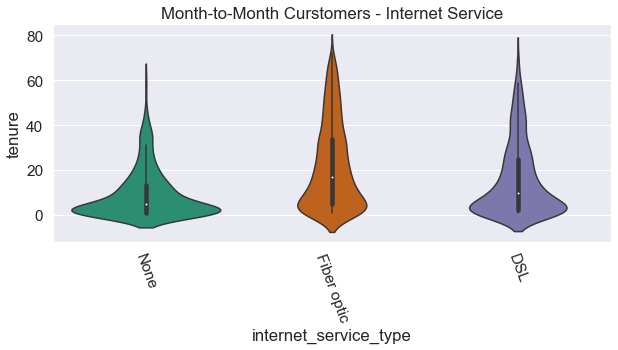

In [39]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 1)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot('internet_service_type', 'tenure', data = study_mo, split=True, palette="Dark2", ax = ax1)
plt.title('Month-to-Month Curstomers - Internet Service')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=-70)

# name_of_plot.fig.savefig(figure_output_path)  

(array([0, 1]), <a list of 2 Text xticklabel objects>)

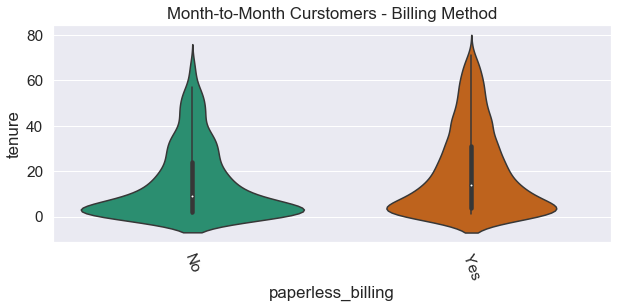

In [35]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 1)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot('paperless_billing', 'tenure', data = study_mo, split=True, palette="Dark2", ax = ax1)
plt.title('Month-to-Month Curstomers - Billing Method')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=-70)

# name_of_plot.fig.savefig(figure_output_path)  

In [17]:
wo_paper = train[(train.paperless_billing == "No") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [18]:
w_paper = train[(train.paperless_billing == "Yes") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [22]:
print("Average tenure of monthly customers WITH PAPERLESS BILL:")
print("{}".format(round(w_paper)))

print("Average tenure of monthly customers WITHOUT PAPERLESS BILL:")
print("{}".format(round(wo_paper)))

print("Difference in avg tenure between with or without PAPERLESS BILL:")
print("{}".format(round(w_paper - wo_paper)))

Average tenure of monthly customers WITH PAPERLESS BILL:
20
Average tenure of monthly customers WITHOUT PAPERLESS BILL:
15
Difference in avg tenure between with or without PAPERLESS BILL:
5


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

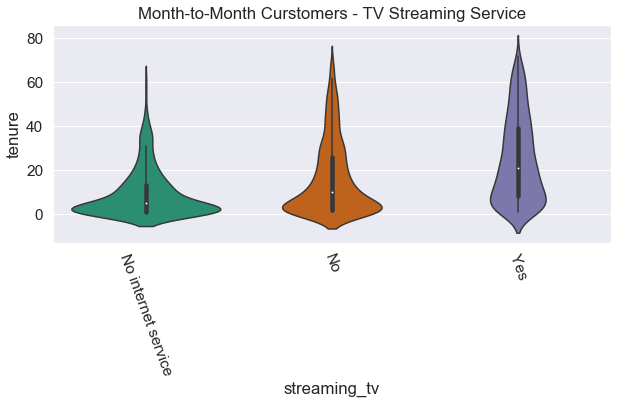

In [37]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 1)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot('streaming_tv', 'tenure', data = study_mo, split=True, palette="Dark2", ax = ax1)
plt.title('Month-to-Month Curstomers - TV Streaming Service')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=-70)

# name_of_plot.fig.savefig(figure_output_path)  

In [24]:
w_stv = train[(train.streaming_tv == "Yes") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [25]:
wo_stv = train[(train.streaming_tv == "No") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [27]:
print("Average tenure of monthly customers Subscribed TV Streaming:")
print("{}".format(round(w_stv)))

print("Average tenure of monthly customers WITHOUT TV Streaming:")
print("{}".format(round(wo_stv)))

print("Difference in avg tenure between with or without TV Streaming:")
print("{}".format(round(w_stv - wo_stv)))

Average tenure of monthly customers Subscribed TV Streaming:
25
Average tenure of monthly customers WITHOUT TV Streaming:
16
Difference in avg tenure between with or without TV Streaming:
9


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

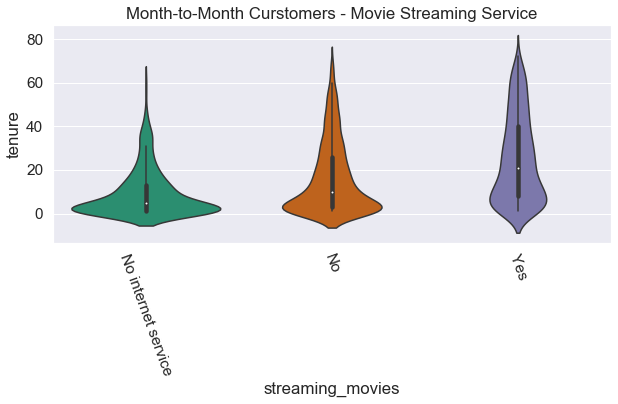

In [38]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 1)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
sns.violinplot('streaming_movies', 'tenure',  data = study_mo, split=True, palette="Dark2", ax = ax1)
plt.title('Month-to-Month Curstomers - Movie Streaming Service')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=-70)

# name_of_plot.fig.savefig(figure_output_path)  

In [29]:
w_mo = train[(train.streaming_movies == "Yes") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [30]:
wo_mo = train[(train.streaming_movies == "No") & (train.Monthly_or_not == "Monthly")].tenure.mean()

In [31]:
print("Average tenure of monthly customers Subscribed Movie Streaming:")
print("{}".format(round(w_mo)))

print("Average tenure of monthly customers WITHOUT Movie Streaming:")
print("{}".format(round(wo_mo)))

print("Difference in avg tenure between with or without Movie Streaming Subscription:")
print("{}".format(round(w_mo - wo_mo)))

Average tenure of monthly customers Subscribed Movie Streaming:
25
Average tenure of monthly customers WITHOUT Movie Streaming:
16
Difference in avg tenure between with or without Movie Streaming Subscription:
9


**Takeaway** Within the monthly customer population, potential room to improve tenure including promotion of following:
- auto payment (either with credit card or bank transfer) 
- paperless billing
- fiber optic service
- streaming tv
- streaming movie

# Prepare MVP & Key Qeustions

**Q1** Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

**Takeaway** The overall trend indicates the most customer churn appear in the first 5 months.

Text(0.5, 1.0, 'Churn Rate For Each Tenure Period')

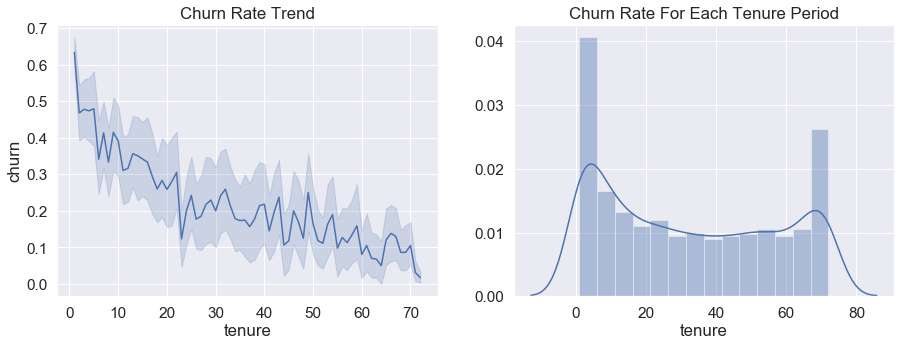

In [140]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2)
sns.set(font_scale=1.4)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

sns.lineplot(x="tenure", y="churn", data=train, ax = ax1).set_title("Churn Rate Trend")
sns.distplot(train[["tenure","churn"]].tenure, ax = ax2).set_title("Churn Rate For Each Tenure Period")

**Q2: Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?**

Are there features that indicate a higher propensity to churn?

- internet service

- type of phone service

- type of online security and backup

- senior citizens

- paying more than x% of customers with the same services > a way to filter (even just using SQL, to find same service but different prices, does that lead to more churn?

**Takeaway**

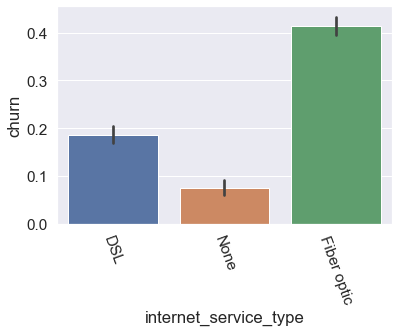

In [152]:
fig = sns.barplot(x="internet_service_type", y="churn", data=train_1)
fig.set_xticklabels(['DSL', 'None', 'Fiber optic'])
plt.xticks(rotation=-70)
plt.show()

In [153]:
observed = pd.crosstab(train_1.internet_service_type_id, train_1.churn)
observed
chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)

chi2:  574.7296533219021
p-value:  1.5813991027929435e-125
degrees of freedom 2
expected values
 [[1422.43555556  505.56444444]
 [1818.62222222  646.37777778]
 [ 908.94222222  323.05777778]]


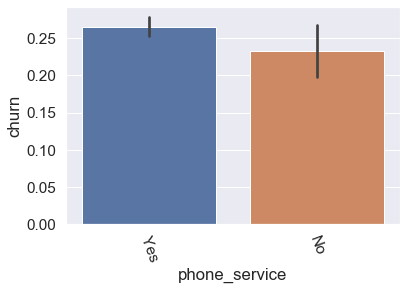

In [155]:
fig = sns.barplot(x="phone_service", y="churn", data=train_1)
fig.set_xticklabels(['Yes','No'])
plt.xticks(rotation=-70)
plt.show()

In [156]:
train, test = prep.encode(train, test, "phone_service")
observed = pd.crosstab(train.phone_service, train.churn)
observed
chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)

chi2:  2.574877593746905
p-value:  0.10857249991420448
degrees of freedom 1
expected values
 [[ 405.77777778  144.22222222]
 [3744.22222222 1330.77777778]]


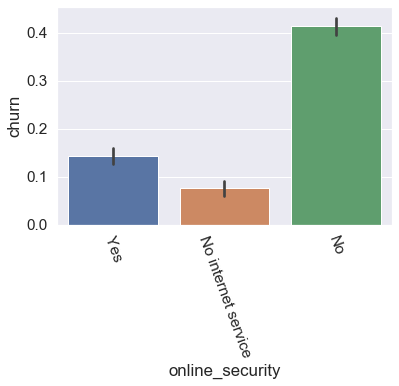

In [157]:
fig = sns.barplot(x="online_security", y="churn", data=train)
#fig.set_xticklabels(['Yes','No'])
plt.xticks(rotation=-70)
plt.show()

In [158]:
train, test = prep.encode(train, test, "online_security")
observed = pd.crosstab(train.online_security, train.churn)
observed
chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)

chi2:  669.8892499754118
p-value:  3.430817563307424e-146
degrees of freedom 2
expected values
 [[2057.66222222  731.33777778]
 [ 908.94222222  323.05777778]
 [1183.39555556  420.60444444]]


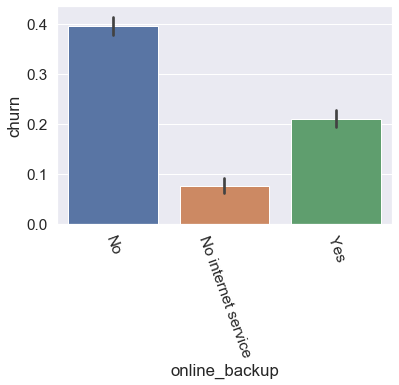

In [159]:
fig = sns.barplot(x="online_backup", y="churn", data=train)
#fig.set_xticklabels(['Yes','No'])
plt.xticks(rotation=-70)
plt.show()

In [160]:
train, test = prep.encode(train, test, "online_backup")

observed = pd.crosstab(train.online_backup, train.churn)
observed
chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)

chi2:  475.8904701823917
p-value:  4.588781774248581e-104
degrees of freedom 2
expected values
 [[1819.36        646.64      ]
 [ 908.94222222  323.05777778]
 [1421.69777778  505.30222222]]


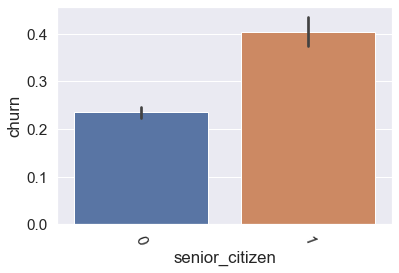

In [161]:
fig = sns.barplot(x="senior_citizen", y="churn", data=train)
#fig.set_xticklabels(['Yes','No'])
plt.xticks(rotation=-70)
plt.show()

In [162]:
observed = pd.crosstab(train.senior_citizen, train.churn)
observed
chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)

chi2:  109.89218595509097
p-value:  1.0346793483630748e-25
degrees of freedom 1
expected values
 [[3488.95111111 1240.04888889]
 [ 661.04888889  234.95111111]]


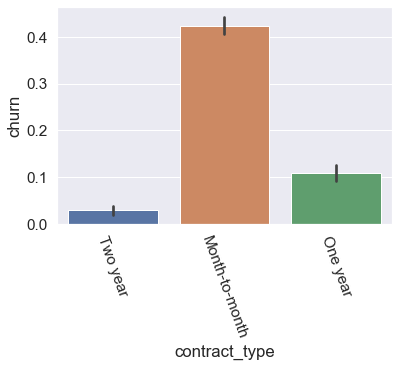

In [163]:
fig = sns.barplot(x="contract_type", y="churn", data=train)
#fig.set_xticklabels(['Yes','No'])
plt.xticks(rotation=-70)
plt.show()

In [164]:
observed = pd.crosstab(train.contract_type, train.churn)
observed
chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)

chi2:  938.1384918529661
p-value:  1.9311449093297486e-204
degrees of freedom 2
expected values
 [[2275.30666667  808.69333333]
 [ 875.00444444  310.99555556]
 [ 999.68888889  355.31111111]]


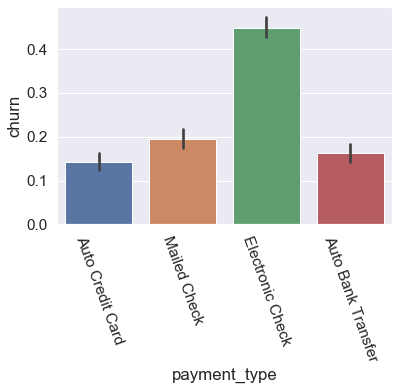

In [165]:
fig = sns.barplot(x="payment_type", y="churn", data=train)
fig.set_xticklabels(["Auto Credit Card", "Mailed Check","Electronic Check", "Auto Bank Transfer"])
plt.xticks(rotation=-70)
plt.show()

In [166]:
observed = pd.crosstab(train.payment_type, train.churn)
observed
chi2, p, degf, expected = sp.stats.chi2_contingency(observed)
print('chi2: ', chi2)
print('p-value: ', p)
print('degrees of freedom', degf)
print('expected values\n', expected)

chi2:  523.0204934262584
p-value:  4.892944570588609e-113
degrees of freedom 3
expected values
 [[ 892.71111111  317.28888889]
 [ 891.23555556  316.76444444]
 [1399.56444444  497.43555556]
 [ 966.48888889  343.51111111]]


In [ ]:
# create new train and test for updated model and more exploration/ vis
# train 80%/ test 20%
# randomseed = 123
train_1, test_1 = prep.split_my_data(df)

In [ ]:
# encode churn value for plotting
train_1, test_1 = prep.encode(train_1, test_1, "churn")

In [173]:
# remove redundant col
# drop col already established in the original dataset
train_1.drop(columns=["payment_type_id","contract_type_id","internet_service_type_id"], inplace=True)
test_1.drop(columns=["payment_type_id","contract_type_id","internet_service_type_id"], inplace=True)

**Takeaway**
High/ Medium correlation
- Tenure, total_charges, monthly_charges
- Churn inversely correlated with total_charges???
- Senior_citizen & monthly_charges/ churn

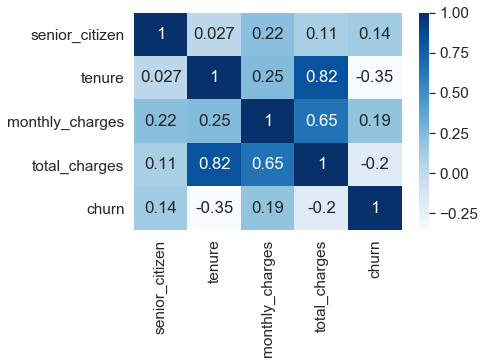

In [175]:
sns.heatmap(train_1.corr(), cmap='Blues', annot = True)
plt.show()

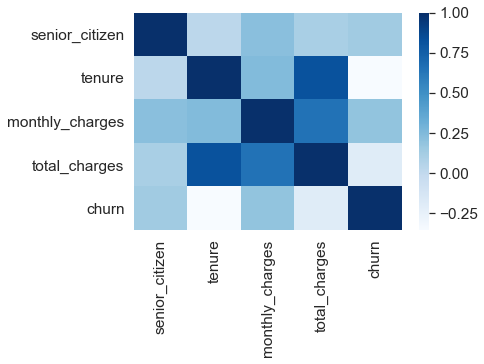

In [176]:
sns.heatmap(train_1.corr(), cmap='Blues')
plt.show()

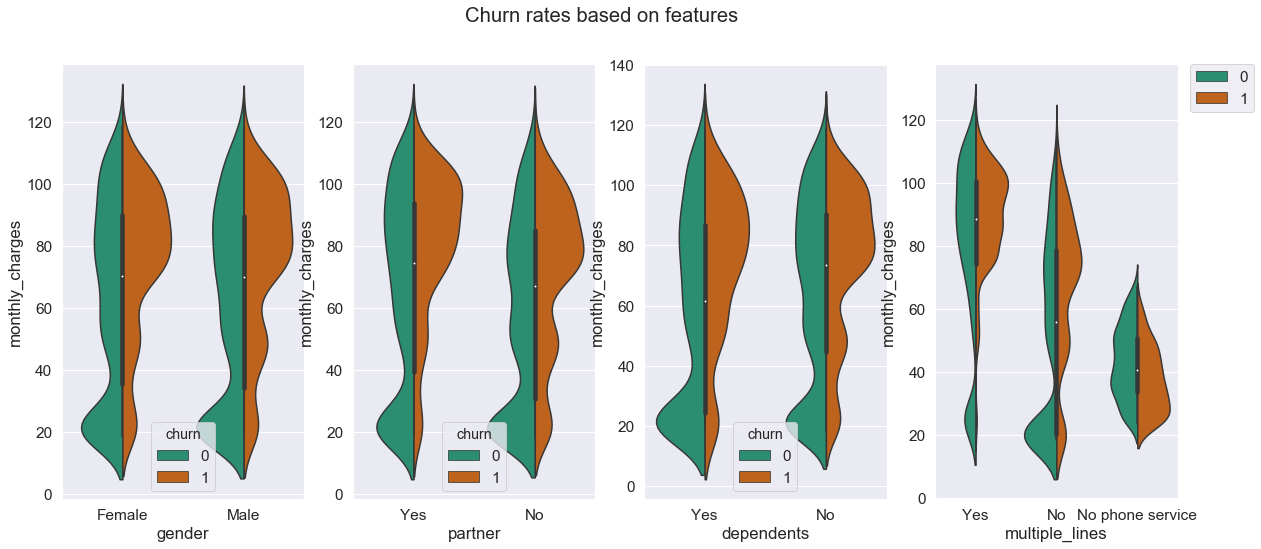

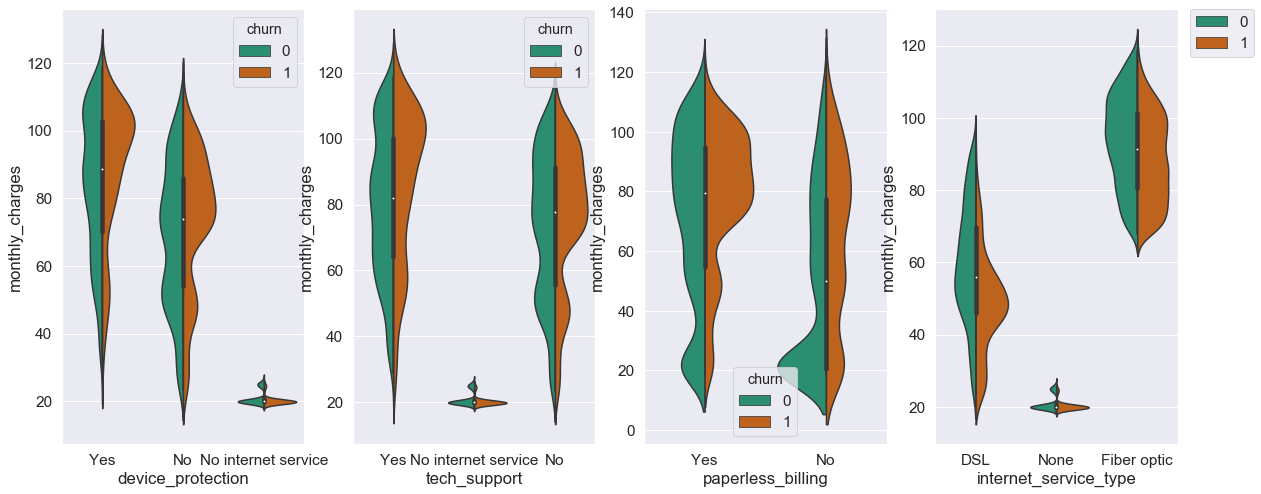

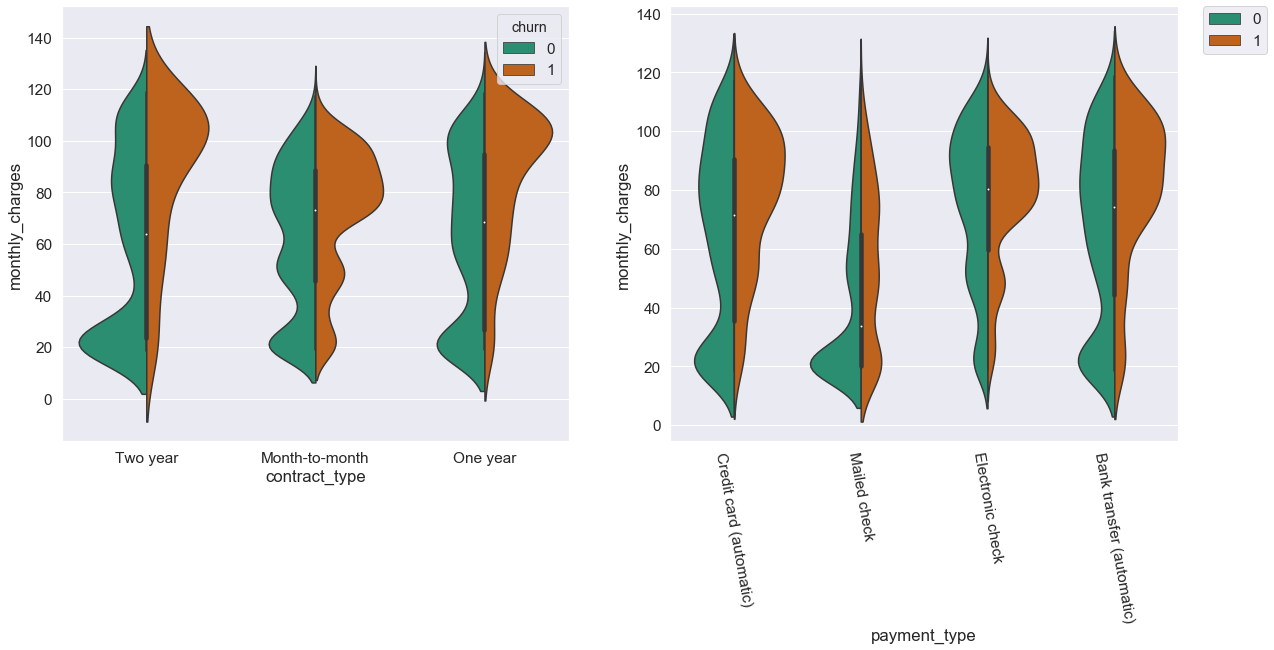

In [191]:
features = ['gender', 'partner', 'dependents', 'multiple_lines']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train, split=True, ax=ax[i], palette="Dark2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('Churn rates based on features')


features = ['device_protection', 'tech_support', 'paperless_billing', 'internet_service_type']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train, split=True, ax=ax[i], palette="Dark2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    
features = ['contract_type', 'payment_type']
_, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train, split=True, ax=ax[i], palette="Dark2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xticks(rotation=-80)
plt.show()